# Анализ кластеров за 2016 год

In [1]:
import json
import numpy as np
from itertools import groupby
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import spatial

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import datetime
from matplotlib.dates import MO
from random import shuffle

%matplotlib notebook

In [46]:
import math
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt


class HistResult:
    # Матрица с результатами, в виде списка таплов: (mi, ln_mi, variance, ln_variance)
    matrix = []
    
    # коэффициет b
    slope = 0
    
    # свободный коэффициет k
    intercept = 0
    
    # коэффициент корелляции
    correlation_coefficient = 0
    
    # коэффициент Харста
    hirst_coefficient = 0
    
    def __init__(self, matrix, slope, intercept, correlation_coefficient, hirst_coefficient):
        self.matrix = matrix
        self.slope = slope
        self.intercept = intercept
        self.correlation_coefficient = correlation_coefficient
        self.hirst_coefficient = hirst_coefficient
        
    def print_result(self): 
        print("---")
        for mi, ln_mi, variance, ln_variance in self.matrix:
            print("mi: 1/%s, variance: %s, ln(variance): %s, ln(m): %s)" % (mi, variance, ln_variance, ln_mi))
        
        print("---")
        print("y = %s * x + %s" %(self.slope, self.intercept))
        print("Correlation coefficient = %s" % self.correlation_coefficient)
        print("Hirst Coefficient = %s" % self.hirst_coefficient)
            
    def plot(self, height = 5, width = 10, font_size = 12):
        plt.rcParams['figure.figsize'] = (width, height)
        plt.rcParams['font.size'] = font_size
        
        fig, ax = plt.subplots()
        
        x = [x[1] for x in self.matrix]
        y = [y[3] for y in self.matrix]
        
        x1 = []
        y1 = []

        for xx in np.arange(min(x) - 0.1, max(x) + 0.1, 0.1):
            x1.append(xx)
            y1.append(self.slope * xx + self.intercept)
        
        ax.scatter(x, y)
        ax.plot(x1, y1)
        
        fig.show()

class SelfSimilarityHirst:
    """
        Самоподобие Херста
    """
    
    def __blocks_split(self, arr, size):
        """
            Делит входной массив на блоки указанного размера,
            например arr = [1, 2, 3, 4, 5], size = 2,
            результат: [[1, 2], [3, 4]]
            отбрасывает элементы для которых не хватает блоков
        """
        blocks = []
        pos = 0
        for i in range(size, len(arr) + 1, size):
            blocks.append(arr[pos:i])
            pos = pos + size
        return blocks

    def __expected_value(self, arr):
        """
            Математическое ожидание (среднее)
        """
        return sum(arr) / len(arr)

    def __variance(self, arr, exp):
        """
            Дисперсия
        """
        d = [math.pow(x - exp, 2) for x in arr]
        return sum(d) / len(d)
    
    def __block_count(self, data_len):
        """
            Рассчитывает количество блоков
        """
        return int(data_len / 2)
    
    def __variance_matrix(self, data, log_base):
        """
            Рассчитывает зависимость логарифма среднего значения дисперсии от логарифма mi
        """
        result = []
        
        last_cnt = -1
        
        block_count = self.__block_count(len(data))
        
        for mi in range(block_count, 0, -1):
            block_cnt = int(len(data)/mi)
            
            # Если уже были блоки такого размера, то пропускаем
            if block_cnt == last_cnt:
                continue
            last_cnt = block_cnt
            
            dds = []
            
            # Рассчет среднего и дисперсии для каждого блока
            for block in self.__blocks_split(data, block_cnt):
                vals = [y for x, y in block]
                ev = self.__expected_value(vals)
                v = self.__variance(vals, ev)
                dds.append(v)
               
            # Рассчет среднего значения дисперсий блока
            variance = self.__expected_value(dds)
            
            ln_mi = math.log(1/mi, log_base)
            ln_variance = math.log(variance, log_base)
            
            result.append((mi, ln_mi, variance, ln_variance))
            
        return result
    
    def __regress(self, x, y):
        slope, intercept, correlation_coefficient, p_value, std_err = stats.linregress(x,y)
        h = (2 - slope) / 2
        
        return (slope, intercept, correlation_coefficient, h)
    
    def compute(self, data, log_base = math.e):
        matrix = self.__variance_matrix(data, log_base)
        
        x = [x[1] for x in matrix]
        y = [y[3] for y in matrix]
        
        print("==1==")
        slope, intercept, correlation_coefficient, h = self.__regress(x[0:9], y[0:9])
        print(slope, intercept, correlation_coefficient, h)
        
        print("==2==")
        slope, intercept, correlation_coefficient, h = self.__regress(x[9:], y[9:])
        print(slope, intercept, correlation_coefficient, h)
        
        return HistResult(matrix, slope, intercept, correlation_coefficient, h)

In [3]:
class News:
    def __init__(self, id, date, title, content, url, siteType):
        self.id = id
        self.date = date
        self.title = title
        self.content = content
        self.url = url
        self.siteType = siteType
    
    @classmethod
    def from_json(cls, json_str):
        json_dict = json.loads(json_str)
        return cls(**json_dict)

In [4]:
def filter_words(text):
    words_list = text.split()
    newWords = [x for x in words_list if len(x) > 3]
    return " ".join(newWords)

# Загрузка новостей

In [5]:
news = []
with open('/data/kasandra/year/2016.all.normalized.json', encoding="utf8") as f:
    for line in f:
        news.append(News.from_json(line))
news_map = {n.id: n for n in news}

# Удаление стоп-слов

In [6]:
words = []
for n in news:
    words.extend(n.content.split())
counts = Counter(words)
one_time = [k for k, v in dict(counts).items() if v == 1]
print("total words: %s" % (len(words) - len(one_time)))

total words: 19048075


In [7]:
one_time_words = set(one_time)

# Загрузка результатов кластеризации

In [8]:
news_labels = {}
with open('/data/kasandra/year/result/2016.300.kmeans.json', encoding="utf8") as f:
    news_labels = json.loads(f.read())

In [9]:
cluster_news = {}
for n_id, label in news_labels.items():
    if label in cluster_news:
        n_list = cluster_news[label]
        n_list.append(news_map[n_id])
    else:
        n_list = []
        n_list.append(news_map[n_id])
        cluster_news[label] = n_list

# Векторизация

In [10]:
news_constent = [filter_words(x.content) for x in news]

In [11]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True, tokenizer=lambda text: text.split(" "), stop_words=one_time_words,
                                   max_df=0.5, min_df=2, norm='l2')

tfidf_matrix = tfidf_vectorizer.fit_transform(news_constent)
print("vocabulary size: %s" % len(tfidf_vectorizer.vocabulary_))

vocabulary size: 95475


# Количество новостей в кластерах

In [12]:
titles = [n.title for n in cluster_news[74]]
titles[:10]

['Белорусские спортсмены пронесут российский флаг во время открытия Паралимпиады',
 'Белорусские паралимпийцы пронесли флаг России на открытии Игр в Рио',
 'МПК устанавливает личность белоруса, вынесшего флаг России на "Маракане"',
 'IPC расследует вынос флага России белорусами на открытии Игр',
 'МПК заинтересовался личностью пронесшего флаг России белорусского паралимпийца',
 'IPC проведет расследование в отношении белорусов за вынос российского флага',
 'IPC опознал белоруса, несшего российский флаг на открытии Паралимпиады',
 'Личность пронесшего флаг России на открытии Паралимпиады белоруса установлена',
 'Паралимпийцев из Белоруссии накажут за вынос российского флага',
 'Паралимпийский комитет идентифицировал белорусского атлета, пронёсшего флаг РФ']

# Сегментирование кластеров по дням

In [13]:
# 2016
start_year = 1451595600 * 1000
end_year = 1483217999 * 1000 + 1
day_millis = 24 * 60 * 60 * 1000

## Сегментация по конкретным дням

In [14]:
def segment_news_daily(seg_news):
    segmented_news = {}
    for start_day in range(start_year, end_year, day_millis):
        end_day = start_day + day_millis
        cur_news = [n for n in seg_news if n.date >= start_day and n.date < end_day]
        segmented_news[start_day] = cur_news
    return segmented_news

# Вычисление отклонений для кластера

In [15]:
# year_centrid = np.array(tfidf_matrix.mean(axis=0))[0]
year_centrid = np.empty(tfidf_matrix.shape[1])
year_centrid.fill(1)

In [16]:
def day_cos(day_news):
    cos_news = {}
    for day, d_news in day_news.items():
        if len(d_news) > 0:
            content_day = [filter_words(x.content) for x in d_news]
            tfidf_day = tfidf_vectorizer.transform(content_day)
            day_centroid = np.array(tfidf_day.mean(axis=0))[0]
            cos_news[day] = 1 - spatial.distance.cosine(year_centrid, day_centroid)
        else:
            cos_news[day] = 0
    return cos_news

# Отрисовка графика

In [17]:
def plot_cos_centroid(cos_days, start_day, end_day, label):
    # plt.rcParams['figure.figsize'] = (20.0, 8.0)
    # plt.rcParams['font.size'] = 12
    fig, ax = plt.subplots()

    myFmt = mdates.DateFormatter('%d.%m.%Y')
    ax.xaxis.set_major_formatter(myFmt)
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO))

    datemin = datetime.datetime.fromtimestamp(start_day/1000) - datetime.timedelta(days=7)
    datemax = datetime.datetime.fromtimestamp(end_day/1000) + datetime.timedelta(days=7)
    ax.set_xlim(datemin, datemax)
    
    x = []
    y = []
    
    sorted_dates = sorted(list(cos_days.keys()))
    
    for ddd in sorted_dates:
        x.append(datetime.datetime.fromtimestamp(ddd/1000))
        y.append(cos_days[ddd])

    ax.plot(x, y, label = label)
    ax.legend(loc='upper right')
    fig.autofmt_xdate(rotation=60)
    fig.show()

# Вывод N первых новостей из кластера

In [18]:
def print_news(cl_news, n, cl_label):
    rand_news = []
    rand_news.extend(cl_news)
    shuffle(rand_news)
    
    print("cluster: %s, %s из %s новостей:" %(cl_label, n, len(cl_news)))
    for nn in rand_news[:n]:
        print("\t %s" % nn.title)

# Отображение сегментов

In [19]:
def compute_for_cluster(segment_method, cl_news, cluster_number):
    segmented_news = segment_method(cl_news)
    cos_news = day_cos(segmented_news)
    
    return cos_news

In [20]:
def plot_sgmented_cluster(cos_news, cluster_number, cl_news):
    print("График для кластера: %s" % (cluster_number))
    plot_cos_centroid(cos_news, start_year, end_year, cluster_number)
    print_news(cl_news, 10, cluster_number)
    print("----------------------")

# Фильтрация кластеров
убираем нулевой кластер и кластеры с маленьким количеством новостей

In [21]:
max_cluster_size = 600
mix_cluster_size = 200

In [22]:
medium_clusters = {k: v for k, v in cluster_news.items() if len(v) >= mix_cluster_size and len(v) <= max_cluster_size }
print("count clusters: %s" % len(medium_clusters))

count clusters: 129


# Графики

## Сегментация по дням

In [63]:
cos_results = []
start_t = time.time()
for c_label, c_news in medium_clusters.items():
    day_cos_res = compute_for_cluster(segment_news_daily, c_news, c_label)
    cos_results.append((c_label, c_news, day_cos_res))
    
print(time.time() - start_t)

179.32910799980164


# Анализ самоподобия

In [59]:
import time

In [61]:
time.time()

1511032676.968034

In [62]:
start_t = time.time()
hirst_results = []
for c_label, c_news, dd_cos in cos_results:
    hist = SelfSimilarityHirst()
    itemms = list(dd_cos.items())
    try:
        h_res = hist.compute(itemms)
    except Exception:
        print("bad cluster: %s, count news: %s" % (c_label, len(c_news)))
        continue
    
    hirst_results.append((c_label, c_news, dd_cos, h_res))
    
print(time.time() - start_t)

--91--
==1==
0.385926441783 -7.1925109083 0.959039753101 0.807036779108
==2==
0.0699275650457 -8.36252821778 0.927232197305 0.965036217477
--40--
==1==
0.411730478892 -6.42583974547 0.949525296762 0.794134760554
==2==
0.0528619764326 -7.76707877387 0.934999948522 0.973569011784
--223--
==1==
0.405430067838 -6.11209184239 0.962766966909 0.797284966081
==2==
0.0309683320095 -7.47727830101 0.859494469377 0.984515833995
--163--
==1==
0.329599980813 -7.6166298052 0.960883277527 0.835200009594
==2==
0.0439973816867 -8.67995074116 0.956524198317 0.978001309157
--176--
==1==
0.38382646547 -6.68002354397 0.9547965752 0.808086767265
==2==
0.0392518923556 -7.94101374898 0.903581860688 0.980374053822
--51--
==1==
0.345822089669 -6.99227879783 0.961925077129 0.827088955166
==2==
0.0589644529777 -8.05635048277 0.885898559313 0.970517773511
--281--
==1==
0.419309826249 -6.84700613258 0.951004931806 0.790345086876
==2==
0.0645530626506 -8.13984424324 0.89910428309 0.967723468675
--77--
==1==
0.4030025

In [26]:
best_clust = [103, 206, 283]

In [27]:
best_res = list(filter(lambda x: x[0] in best_clust, hirst_results))

In [28]:
len(best_res)

3

In [95]:
best_res[0][2]

{1451595600000: 0,
 1451682000000: 0.046015765267064634,
 1451768400000: 0.058271352082238104,
 1451854800000: 0.043034713608965713,
 1451941200000: 0.029394468982294586,
 1452027600000: 0.019693549219790496,
 1452114000000: 0.025392351572740779,
 1452200400000: 0.024174322362737533,
 1452286800000: 0.025389549916109977,
 1452373200000: 0.021655028636963336,
 1452459600000: 0.038452241229644302,
 1452546000000: 0,
 1452632400000: 0,
 1452718800000: 0,
 1452805200000: 0.0501044305635725,
 1452891600000: 0.027557676001358389,
 1452978000000: 0,
 1453064400000: 0.023738698148951909,
 1453150800000: 0.040060135153611176,
 1453237200000: 0.043890584011114786,
 1453323600000: 0,
 1453410000000: 0,
 1453496400000: 0,
 1453582800000: 0,
 1453669200000: 0.049823929908756392,
 1453755600000: 0,
 1453842000000: 0,
 1453928400000: 0.032683266472635419,
 1454014800000: 0.022087026665265297,
 1454101200000: 0,
 1454187600000: 0,
 1454274000000: 0,
 1454360400000: 0.023722238196439038,
 1454446800000

In [32]:
def int_norm(d):
    return str(d).replace(".", ",")

In [33]:
int_norm(0.1)

'0,1'

In [34]:
import csv

In [36]:
for c_label, c_news, dd_cos, h_res in best_res:
    with open(("/data/kasandra/clus_hurst_res/%s.clust" % c_label), 'w') as csvfile:
        spamwriter = csv.writer(csvfile, delimiter='\t')
        for d in dd_cos.items():
            spamwriter.writerow([d[0], int_norm(d[1])])
    with open(("/data/kasandra/clus_hurst_res/%s.hurst" % c_label), 'w') as csvfile:
        spamwriter = csv.writer(csvfile, delimiter='\t')
        for d in h_res.matrix:
            spamwriter.writerow([int_norm(d[1]), int_norm(d[3])])

---График для кластера: 283


<IPython.core.display.Javascript object>


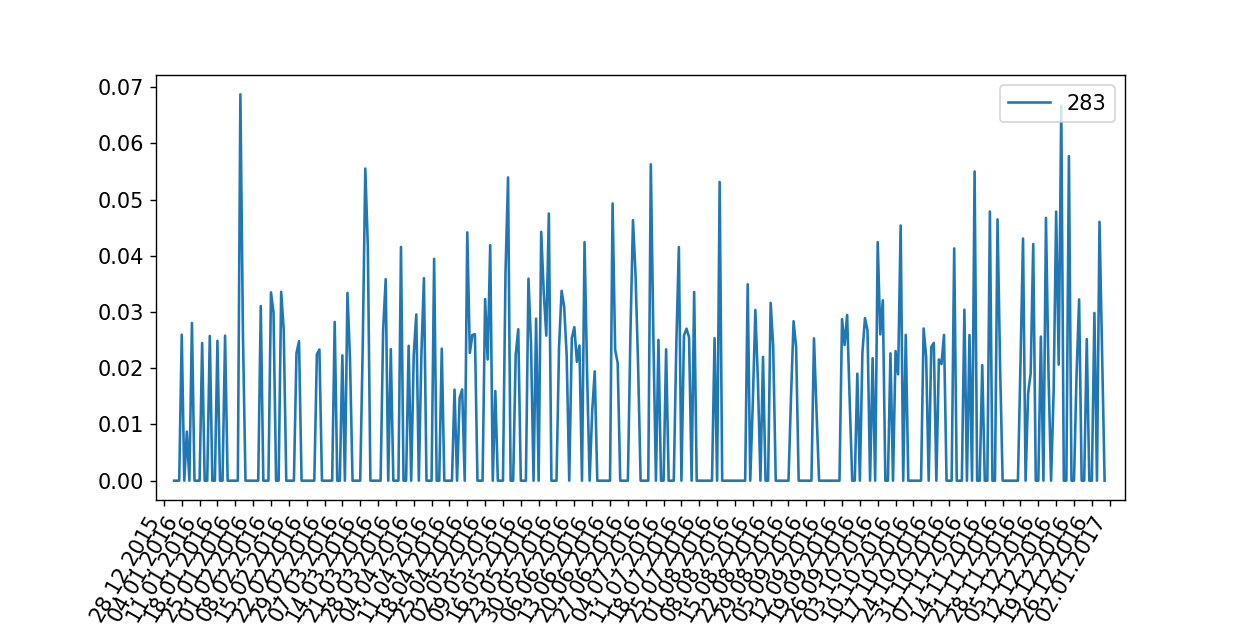

cluster: 283, 30 из 232 новостей:
	 Почему российские сериалы прерывают на середине показа
	 В "Игре Престолов" появится ещё один Старк
	 «Друзей» заново перевели на русский язык
	 Звезда "Игры престолов" появится в спин-оффе "Звёздных войн"
	 Шон Бин сыграл Нэда Старка ради смеха
	 Создателя «Игры престолов» обвинили во всех бедах 2016 года
	 Кто умрет в «Игре престолов» следующим?
	 Названы лучшие телесериалы 2016 года
	 Предполагаемый сценарий нового сезона "Игры престолов" выложен в Сети
	 Журналист вычислил «уродливого голого мужика» из «Друзей»
	 Вдове Вознесенского не понравилась постельная сцена в «Таинственной страсти»
	 Обнародовано краткое содержание продолжения «Твин Пикса»
	 The Telegraph рассказала о ребенке доктора Ватсона из «Шерлока»
	 Выбираем самое неудачное платье на премии "Эмми-2016"
	 Джон Сноу вернется в новый сезон «Игры престолов» мертвым
	 В описании «Игры престолов» раскрыли судьбу Джона Сноу
	 Названы сроки выхода четвертого сезона «Шерлока»
	 Четвертый сез

<IPython.core.display.Javascript object>


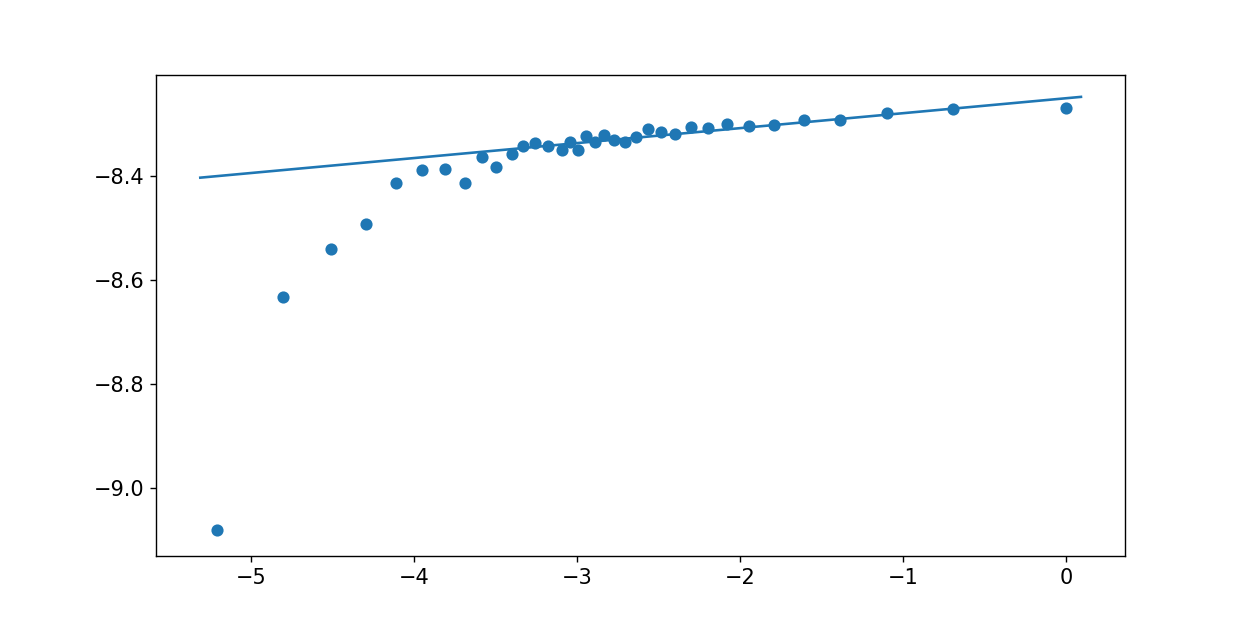

----------------------
---График для кластера: 103


<IPython.core.display.Javascript object>


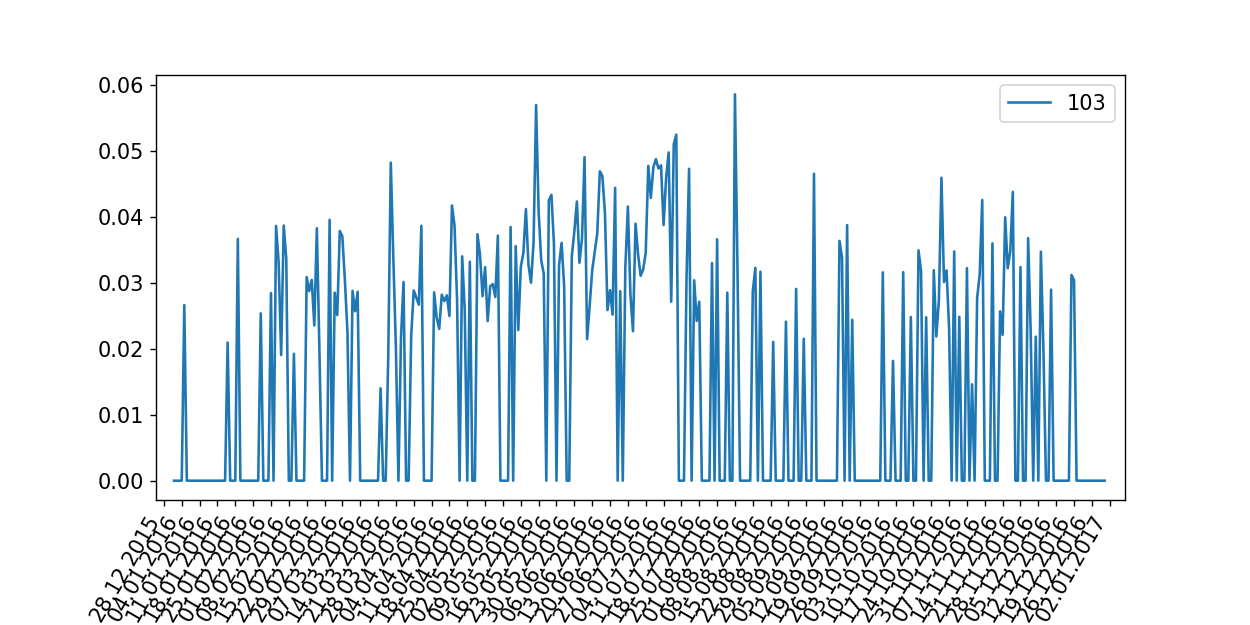

cluster: 103, 30 из 500 новостей:
	 NY Times: Единство НАТО дало трещины после испытания Россией
	 Грушко: Россия ответит на меры НАТО по усилению присутствия на востоке
	 В НАТО признали свою уязвимость для российских войск
	 Россия симметрично ответит на любое усиление НАТО на востоке
	 WSJ: европейские страны не хотят сдерживать Россию вместе с НАТО
	 Министр обороны Британии: Диалог с РФ полезен, но значима и политика сдерживания
	 В Москве ответили на решения Варшавского саммита НАТО
	 В НАТО пообещали нарастить военное присутствие в Черноморском регионе
	 В ГД рассказали, как Россия может ответить на вступление Швеции в НАТО
	 СМИ: Обама намерен призвать Германию усилить восточные границы НАТО
	 Столтенберг возмутился стремлением РФ восстановить свою сферу влияния
	 Трамп предложил поберечь деньги США в войне с ИГИЛ
	 СМИ: у НАТО нет четкой стратегии по ведению кибервойны
	 Пушков назвал безумцем британского генерала, предрекшего ядерную войну с Россией
	 Пушков назвал Штайнмайер

<IPython.core.display.Javascript object>


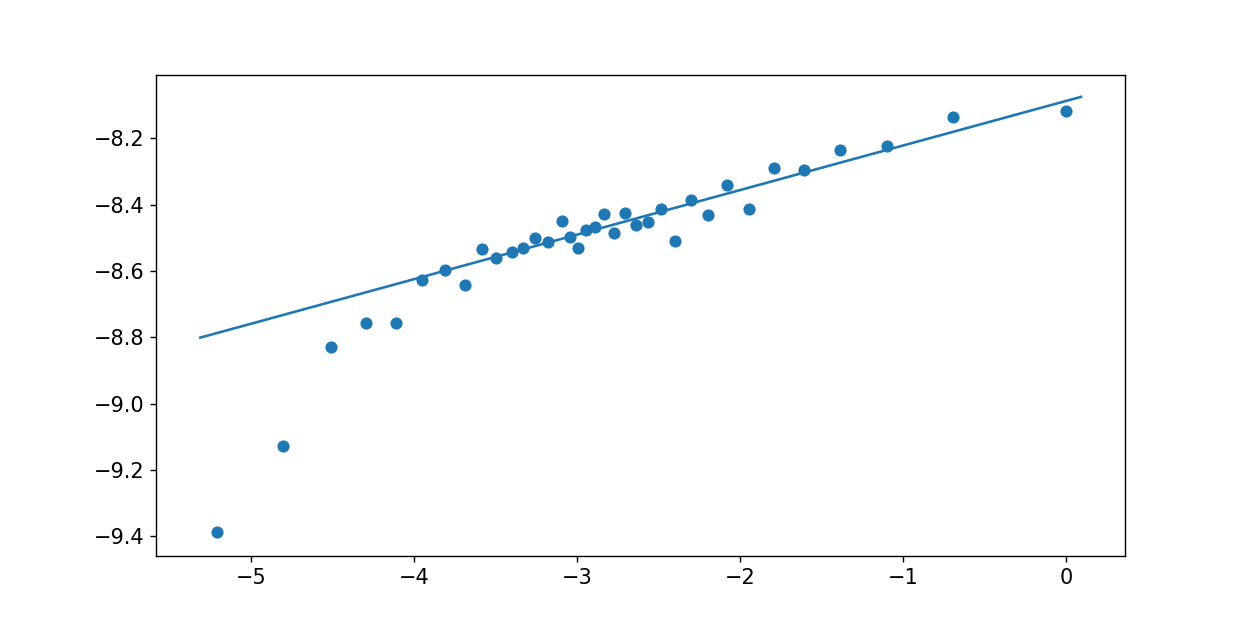

----------------------
---График для кластера: 206


<IPython.core.display.Javascript object>


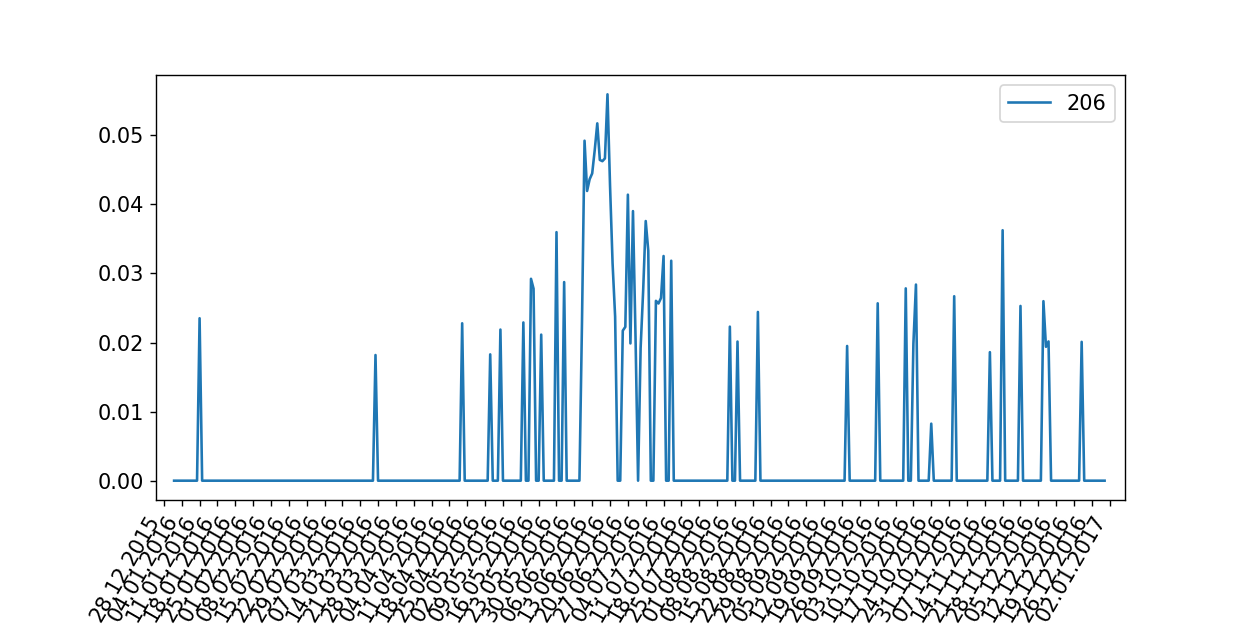

cluster: 206, 30 из 307 новостей:
	 Песков назвал статью Guardian о "кремлевских фанатах" русофобской истерикой
	 Французские власти назвали матч Англия — РФ самым сложным для работы полиции
	 СМИ: Не менее 35 человек пострадали при беспорядках в Марселе
	 Трех российских болельщиков приговорили к тюремному заключению во Франции
	 Самолёт с выдворенными российскими болельщиками вылетел из Ниццы
	 «Мисс Франция» поддержала российских болельщиков на Евро-2016
	 Адвокат Жорин о скандале с братом-болельщиком: «За ложные обвинения в погроме мы можем отсудить у западных таблоидов сотни тысяч евро!»
	 СМИ: Десятки человек были ранены во время беспорядков в фан-зоне Евро в Париже
	 Ветеран фанатских боёв рассказал о негласном кодексе драк ультрас
	 Путин: Не понимаю, как 200 россиян отметелили несколько тысяч англичан
	 Остановленные российские болельщики требуют переводчика и не выходят из автобуса
	 В супермаркетах Лилля перед матчем сборной России запретили продажу алкоголя
	 Российские бол

<IPython.core.display.Javascript object>


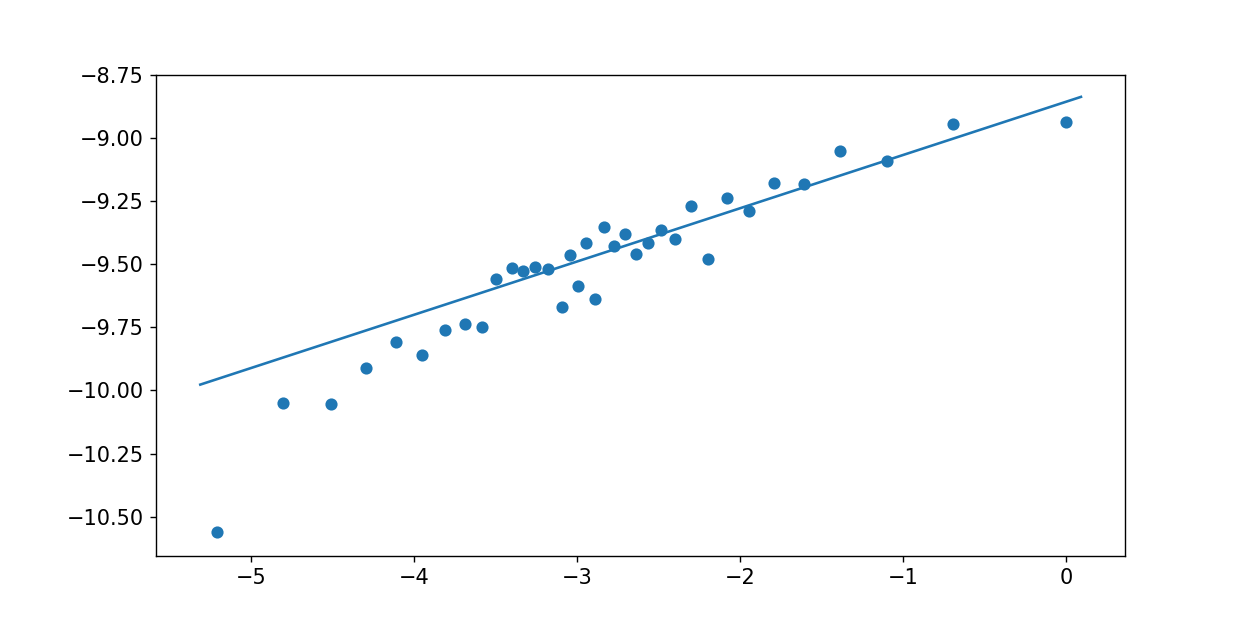

----------------------


In [58]:
for c_label, c_news, dd_cos, h_res in best_res:
    print("---График для кластера: %s" % (c_label))
    plot_cos_centroid(dd_cos, start_year, end_year, c_label)
    print_news(c_news, 30, c_label)
    hist = SelfSimilarityHirst()
    h_res = hist.compute(list(dd_cos.items()))
    print("---Результаты анализа самоподобия кластера")
    h_res.print_result()
    h_res.plot()
    print("----------------------")

In [38]:
sad = [1, 2, 3, 4, 5]

In [43]:
sad[0:2]

[1, 2]

In [41]:
sad[2:]

[3, 4, 5]